In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_daily_temp = pd.read_csv('daily_temperatures.csv')
df_high_blood = pd.read_csv('high_blood_pressure.csv')
print(df_daily_temp.head())
print(df_high_blood.head())

   Daily Average Temperature
0                  28.820262
1                  22.000786
2                  24.893690
3                  31.204466
4                  29.337790
     Id     sex  age  bp_pre  bp_post
0  p001    Male   33     149      129
1  p002    Male   39     168      168
2  p003    Male   70     176      155
3  p004  Female   41     169      178
4  p005    Male   48     160      126


# 데이터 로드
* Daily Average Temperature: 일일 평균 온도, 각 행이 하루의 평균 온도 데이터로 이루어짐

* 혈압 데이터:
    * 사람의 성별, 나이, 혈압의 변화를 기록한 데이터
    * Id: 환자의 고유 식별자
    * sex: 성별 
    * age: 환자의 나이
    * bp_pre: 측정된 초기 혈압 (검사 전 혈압)
    * bp_post: 후속 혈압 (검사 후 혈압)

In [101]:
import pandas as pd
from scipy.stats import shapiro, bartlett, chi2_contingency
from itertools import combinations


class IntegrationTest:
    # 열의 개수와 데이터 타입이 다르므로 동적으로 할당받고 예외처리를 해줘야함
    # 정규성과 등분산성은 숫자만 가능
    # ttset까지 시간 남으면 구현. fxxk 남을리가;;
    def __init__(self, data):
        self.data = data
        self.results = {}  # 결과 저장용 딕셔너리

    def test_normality(self):
        # 정규성 검정 (Shapiro-Wilk Test) - 숫자형 열만 수행
        for column in self.data.select_dtypes(include=['number']).columns:
            stat, p_value = shapiro(self.data[column])
            self.results[f'정규성 {column}'] = p_value > 0.05
            print(f"정규성 검정 (Shapiro-Wilk) - {column}: p-value =", round(p_value,4))
            print(f"정규성 검정 (Shapiro-Wilk) - {column}: T =", round(stat,4))

    def test_homoscedasticity(self):
        # 등분산성 검정 (Bartlett Test) - 모든 숫자형 열 쌍에 대해 수행
        numeric_columns = self.data.select_dtypes(include=['number']).columns
        for col1, col2 in combinations(numeric_columns, 2):
            stat, p_value = bartlett(self.data[col1], self.data[col2])
            self.results[f'등분산성 {col1}, {col2}'] = p_value > 0.05
            # print(f"등분산성 검정 (Bartlett) - {col1} & {col2}: p-value =", p_value) 출력안해도 될듯

    def test_independence(self):
        # 독립성 검정 (Chi-square Test) - 모든 열 쌍에 대해 수행
        for col1, col2 in combinations(self.data.columns, 2):
            # 카이제곱 검정은 범주형 데이터를 대상으로 함
            cross_tab = pd.crosstab(self.data[col1], self.data[col2])
            stat, p_value, x, y = chi2_contingency(cross_tab)
            self.results[f'독립성 {col1}, {col2}'] = p_value > 0.05
            # print(f"독립성 검정 (카이제곱) - {col1} & {col2}: p-value =", p_value)

    def run_all_tests(self):
        # 모든 검정을 실행
        self.test_normality()
        self.test_homoscedasticity()
        self.test_independence()

    def get_results(self):
        # 검정 결과 반환
        return self.results
    
    def print_results(self):
        results = self.get_results()
        print("\n검정 결과:")
        for test_name, result in results.items():
            formatted_name = test_name.replace('_', ' ')
            print(f"{formatted_name}: {'만족' if result else '불만족'}")

# 검증함수 학습
[[통계, Python] 정규성, 독립성, 등분산성 검정 파헤치기 + SciPy를 활용한 파이썬 예제](https://m.blog.naver.com/willie123/222103777303)

         bp_pre     bp_post
age                        
3    163.294118  156.294118
4    164.481481  161.481481
5    161.258065  157.322581
6    163.680000  157.920000
7    166.500000  153.100000


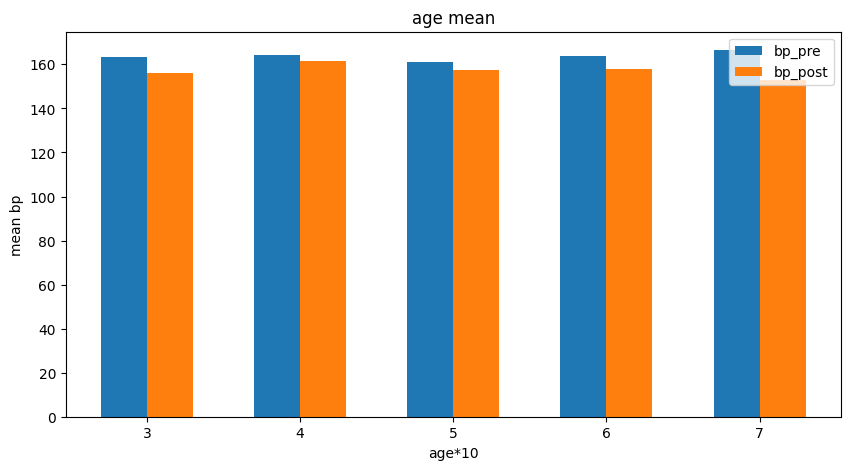

In [93]:
# 나이 별 전후 혈압의 차이
df_temp = df_high_blood[['age', 'bp_pre', 'bp_post']].copy()
df_temp['age'] = df_temp['age']/10
df_temp = df_temp.astype('int64')
df_age_state = df_temp.groupby('age')[['bp_pre','bp_post']].mean()

print(df_age_state.head())

# 히스토그램 출력
plt.figure(figsize=(10, 5))
# 나이를 x축으로, 'bp_pre'와 'bp_post' 평균을 y축으로 설정
plt.bar(df_age_state.index-0.15, df_age_state['bp_pre'], width=0.3, label='bp_pre')
plt.bar(df_age_state.index+0.15, df_age_state['bp_post'], width=0.3, label='bp_post')

plt.xlabel('age*10')
plt.ylabel('mean bp')
plt.title('age mean')
plt.xticks(df_age_state.index)  # x축에 나이값 표시
plt.legend()
plt.show()



### 탐색적 데이터 분석
* 치료 전후에 혈압이 줄긴 함
* 의미 있는 정도인지는 모르겠음

# t 검정 학습
[T-검정 이해하기: 독립 표본 t-검정과 대응 표본 t-검정](https://jae-eun-ai.tistory.com/48)

In [94]:
from scipy.stats import ttest_rel

df_high_blood['div_bp'] = df_high_blood['bp_pre']-df_high_blood['bp_post']

df_div = df_high_blood['div_bp'].mean()
# 클래스 인스턴스 생성 및 검정 실행
test = IntegrationTest(df_high_blood[['age', 'div_bp', 'sex']])
test.run_all_tests()

# 결과 출력
test.print_results()

df_temp = df_high_blood['div_bp'].mean()
print("표본평균 : ", round(df_temp, 2))
T, p_value = map(lambda x: round(x,4), ttest_rel(df_high_blood['bp_post'], df_high_blood['bp_pre']))
print(f"검정통계량: {T}, p-value: {p_value}")



정규성 검정 (Shapiro-Wilk) - age: p-value = 0.005140886006355254
정규성 검정 (Shapiro-Wilk) - age: T = 0.9673299239308354
정규성 검정 (Shapiro-Wilk) - div_bp: p-value = 0.05016313578078596
정규성 검정 (Shapiro-Wilk) - div_bp: T = 0.9783606935166829

검정 결과:
정규성 age: 불만족
정규성 div bp: 만족
등분산성 age, div bp: 불만족
독립성 age, div bp: 만족
독립성 age, sex: 만족
독립성 div bp, sex: 만족
표본평균 :  6.12
검정통계량: -3.0002, p-value: 0.0033


### 분석
혈압차 데이터는 정규성과 독립성은 만족하지만 등분산성을 만족하지 않기 때문에 가설검증에 적합하지 않아보인다.
* 귀무가설 : 고혈압 환자에게 치료는 효과가 없을 것이다.
* 표본평균이 6.12이므로 평균적으로 6.12정도의 치료 전후의 혈압차가 있음
* 검정통계량이 -3.0002이므로 치료 후가 치료 전보다 혈압이 유의미하게 낮음
* p-value가 유의수준인 0.05보다 낮으니 귀무가설을 기각함
* T = 6.12에 해당하는 평균적인 혈압차가 생겼고 치료 후가 치료 전보다 혈압이 낮아졌으며 p-value를 봤을 때 귀무가설을 기각할 수 있으므로 혈압치료는 효과가 있는 것으로 보임

In [95]:
from scipy.stats import ttest_ind

# 데이터 정의
group1 = [36.8, 36.7, 37.1, 36.9, 37.2, 36.8, 36.9, 37.1, 36.7, 37.1]
group2 = [36.5, 36.6, 36.3, 36.6, 36.9, 36.7, 36.7, 36.8, 36.5, 36.7]

df_not_medicine = pd.DataFrame({'temperature' : group1})
df_take_medicine = pd.DataFrame({'temperature' : group2})
test1 = IntegrationTest(df_not_medicine)
test1.run_all_tests()
test2 = IntegrationTest(df_take_medicine)
test2.run_all_tests()
print("not_medicine")
test1.print_results()
print("-----------------")
print("take_medicine")
test2.print_results()

T, p_value = map(lambda x: round(x,4), ttest_ind(df_take_medicine['temperature'], df_not_medicine['temperature']))
print(f"검정통계량: {T}, p-value: {p_value}")
 



정규성 검정 (Shapiro-Wilk) - temperature: p-value = 0.2025800152029294
정규성 검정 (Shapiro-Wilk) - temperature: T = 0.8969133747040112
정규성 검정 (Shapiro-Wilk) - temperature: p-value = 0.8497324952284004
정규성 검정 (Shapiro-Wilk) - temperature: T = 0.9658310017893624
not_medicine

검정 결과:
정규성 temperature: 만족
-----------------
take_medicine

검정 결과:
정규성 temperature: 만족
검정통계량: -3.7964, p-value: 0.0013


### 분석
* 정규성을 만족함
* 귀무가설 : 약 복용이 환자에게 효과가 없을 것이다.
* 검정통계량이 3.7964이므로 약 복용 전과 후의 체온 차가 유의미함 (음수는 상관없음)
* p-value가 유의수준인 0.05보다 낮으니 귀무가설을 기각함
* T = 3.7964에 해당하는 평균적인 체온차가 생겼고 p-value를 봤을 때 귀무가설을 기각할 수 있으므로 약 복용은 효과가 있는 것으로 보임

In [96]:
import scipy.stats as st

test3=IntegrationTest(df_daily_temp)
test3.run_all_tests()
test3.print_results()
# 점 추정 : 평균온도
mean_daily_temp = round(df_daily_temp['Daily Average Temperature'].mean(),2)
print("점 추정 : ", mean_daily_temp)

# 구간 추정 
df = len(df_daily_temp)-1
mu = np.mean(df_daily_temp['Daily Average Temperature'])
se = st.sem(df_daily_temp['Daily Average Temperature'])
min, max = map(lambda x : round(x,4), st.t.interval(0.95,df,loc=mu,scale=se))
print(f"구간추정 95% 신뢰구간:", min, max)


정규성 검정 (Shapiro-Wilk) - Daily Average Temperature: p-value = 0.18591539006380725
정규성 검정 (Shapiro-Wilk) - Daily Average Temperature: T = 0.9942529227389176

검정 결과:
정규성 Daily Average Temperature: 만족
점 추정 :  19.94
구간추정 95% 신뢰구간: 19.4279 20.4473


* [점추정과 구간추정](https://warm-uk.tistory.com/24)
* [신뢰구간 함수](https://jimmy-ai.tistory.com/356)

In [97]:
from scipy.stats import f_oneway

# 각 그룹의 데이터
groupA = [85, 92, 78, 88, 83, 90, 76, 84, 92, 87]
groupB = [79, 69, 84, 78, 79, 83, 79, 81, 86, 88]
groupC = [75, 68, 74, 65, 77, 72, 70, 73, 78, 75]

f_value, p_value = f_oneway(groupA, groupB, groupC)
f_value = round(f_value, 2)
p_value = round(p_value, 6)
print(f"f-value: {f_value}, p-value: {p_value}")

f-value: 16.88, p-value: 1.8e-05


### 분산분석
[f-value와 ANOVA](https://chasingdreams.tistory.com/62)
* f-value가 큰걸 보니 그룹 간 변동이 그룹내 변동보다 크다
* p-value가 0.05보다 작으니 귀무가설을 기각 그룹 간 평균성적의 차이는 통계적으로 유의미한 차이가 있을 가능성이 크다

In [103]:
data = [75, 83, 81, 92, 68, 77, 78, 80, 85, 95, 79, 89]
df_data = pd.DataFrame(data)
test5 = IntegrationTest(df_data)
test5.run_all_tests()
test5.print_results()

정규성 검정 (Shapiro-Wilk) - 0: p-value = 0.9677
정규성 검정 (Shapiro-Wilk) - 0: T = 0.9768

검정 결과:
정규성 0: 만족


T값이 1에 굉장히 가깝기에 정규분포를 따를 가능성이 높음
p-value값이 0.05보다 크기 때문에 귀무가설을 기각할 수 없음, 따라서 데이터는 정규분프를 따를것임